# Assignment 1: Prediction of Airline passengers

**Learning Team 3**
- Francis Mark M. Cayco
- Eros Paul V. Estante
- Andrel Heber M. Jison
- Angela Elaine F. Pelayo

**Masters of Science in Data Science**

COSCI222_0 - Machine Learning 2 


Consider the international airline passengers data from January 1949 to December 1960 here: https://www.kaggle.com/datasets/andreazzini/international-airline-passengers


(1) Forecast using ARIMA the last twelve months (1 year, January-December 1960) with the most optimal choice of p,d,q [10 pts]

(2) Compare the results' RMSE, MAE, and run time with optimal XGBoost. [10 pts]



In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Data Analysis


In [2]:
df = pd.read_csv('assets/international-airline-passengers.csv')
df.columns = ['Date','Passengers']
df.dropna(axis=0, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df_train = df[df['Date'] < '1960-01-01']
df_test = df[df['Date'] >= '1960-01-01']

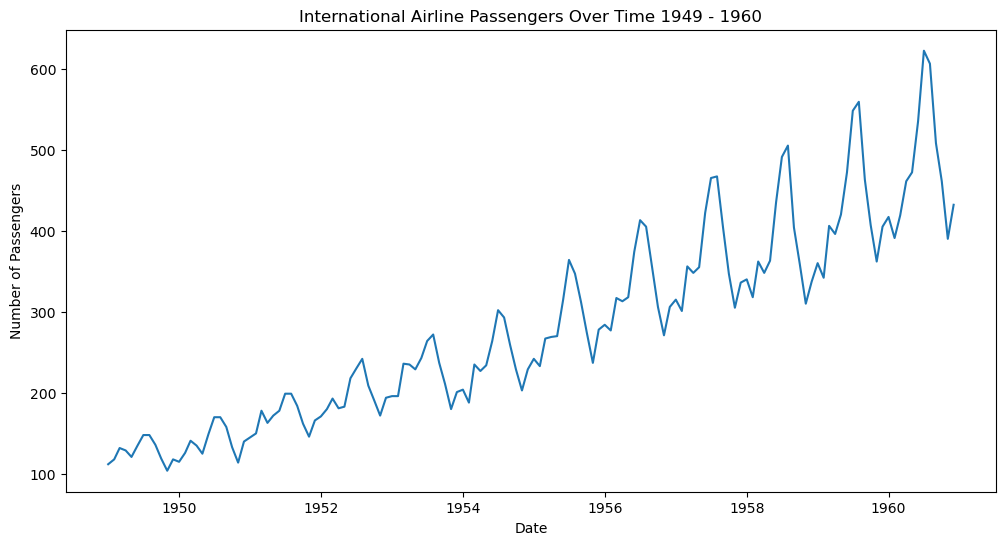

In [7]:
# Plot the data with Date on the x-axis and Passengers on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Passengers'])
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('International Airline Passengers Over Time 1949 - 1960')
plt.show()

Observations:

1. Trend - Shows an upward trend over time, indicating that the number of airline passengers has been increasing steadily.
2. Seasonality - repeating seasonal pattern, with peaks and troughs occurring at yearly intervals.
3. Stationarity - The data is non-stationary, as the mean and variance change over time.

## Seasonal Line Plot

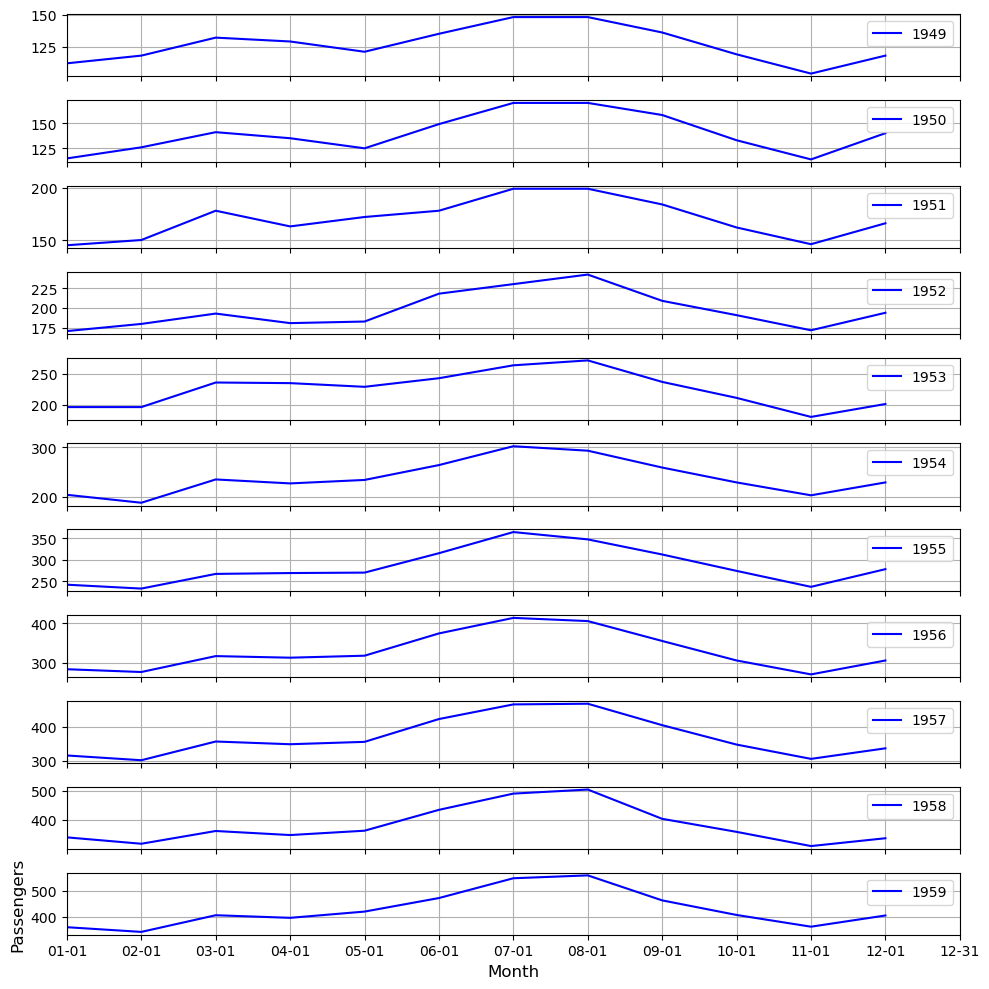

In [21]:
# Set the 'Date' column as index
df_train.set_index('Date', inplace=True)

# Group the training data by year ('A' stands for annual frequency)
groups = df_train.groupby(pd.Grouper(freq='YE'))

# Initialize the plotting area, making sure to accommodate each group
fig, axs = plt.subplots(len(groups), 1, figsize=(10, 10), sharex=True)

# Loop over each group to plot separately
for i, (name, group) in enumerate(groups):
    # Format index to show only the month and day for alignment
    group.index = group.index.strftime('%m-%d')
    
    axs[i].plot(group.index, group['Passengers'], label=f'{name.year}', color='b')
    axs[i].set_xlim(['01-01', '12-31'])  # Set x-axis from January to December
    axs[i].legend(loc='upper right')  # Use the legend to show the year
    axs[i].grid(True)  # Add grid for better visual clarity

# Set common x and y labels
plt.xlabel('Month', fontsize=12)
plt.ylabel('Passengers', fontsize=12)

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()

# Show the plot
plt.show()

Observation

- Seasonality: Similar pattern is observed where peaks usually happens in July & August, and troughs happening in November, and February


- Year-to-Year Consistency: This pattern appears similarly almost every year. While the absolute number of passengers increases over the years, the relative seasonal behavior remains steady, reinforcing the reliability of this pattern for forecasting.

## Density Plot

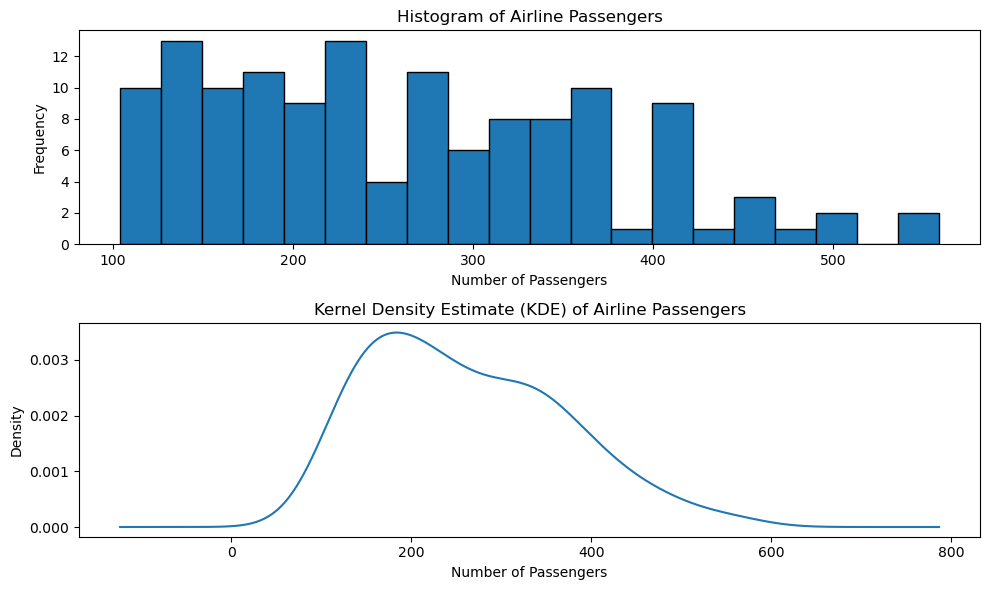

In [14]:
import matplotlib.pyplot as plt

# Extract the 'Passengers' column from the training dataset
series = df_train['Passengers']

# Create the figure for subplots with appropriate size
plt.figure(figsize=(10, 6))

# Create the histogram in the first subplot
plt.subplot(2, 1, 1)
plt.hist(series, bins=20, edgecolor='black')
plt.title('Histogram of Airline Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')

# Create the kernel density estimate (KDE) plot in the second subplot
plt.subplot(2, 1, 2)
series.plot(kind='kde')
plt.title('Kernel Density Estimate (KDE) of Airline Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Observations 

1. Non-Gaussian Distribution - The histogram shows a skewed shape rather than a symmetric bell curve
2. Distribution Shape - The distribution of airline passengers is right-skewed, meaning that most observations are on the lower side with a long tail extending to the right.

## Box and Whiskers Plot

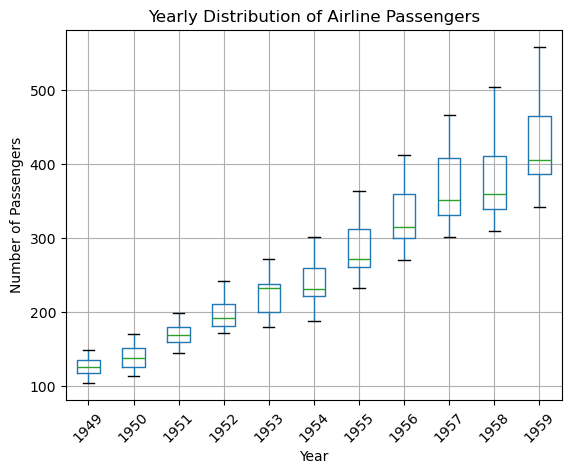

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

series = df_train['Passengers']

# Group the series data by year ('A' stands for annual frequency)
groups = series['1949':'1959'].groupby(pd.Grouper(freq='YE'))

# Create an empty DataFrame to store yearly data
years = pd.DataFrame()

# Loop through each group and store the values in the 'years' DataFrame
for name, group in groups:
    years[name.year] = group.values

# Plot a boxplot for each year
years.boxplot()

# Show the plot
plt.title('Yearly Distribution of Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Observations

1. Median (Green Line) - increases steadily over time. This indicates consistent growth of passengers over time.
2. Spread (Blue Boxes) - size of boxes increases over time, indicating increasing variability - higher flunctuations over time. 
3. Outliers - no significant outliers, indicating stable and reliable data trends.

## Summary of EDA


- Trend: Passenger numbers show a consistent upward trajectory from 1949 to 1959, indicating a strong long-term growth component.
- Seasonality: Clear annual patterns with recurring peaks suggest the presence of seasonal trends, making seasonal adjustments crucial.
- Variability: The increasing spread in passenger numbers over time highlights growing fluctuations that ARIMA models need to accommodate.
- Stationarity Consideration: The upward trend and seasonal effects suggest the need for differencing to achieve stationarity before modeling.


## Forecasting Using ARIMA

In [4]:
p_values = range(0, 10)
d_values = range(0, 1)
q_values = range(0, 10)

In [25]:
model = []
rmse = []
forecasts = []

for p, d, q, in product(p_values, d_values, q_values):
    arima = ARIMA(df_train['Passengers'], order=(p,d,q))
    arima_fit = arima.fit()
    forecast = arima_fit.get_forecast(steps=len(df_test))
    forecast_values = forecast.predicted_mean.values
    forecasts.append(forecast_values)
    model.append((p, d, q))
    rmse.append(root_mean_squared_error(df_test['Passengers'], forecast_values))


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt

In [26]:
best_model = model[np.argmin(rmse)]
# best_forecast = forecast[np.argmin(rmse)]
print('Best Model:', best_model)
print('Root Mean Squared Error:', np.min(rmse))

Best Model: (7, 1, 7)
Root Mean Squared Error: 24.156798424410912


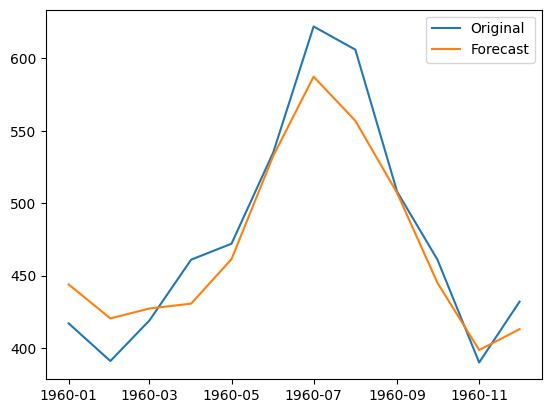

In [31]:
plt.plot(df_test['Date'], df_test['Passengers'], label='Original')
plt.plot(df_test['Date'], forecasts[np.argmin(rmse)], label='Forecast')
plt.legend()


## Forecasting using XGBoost

In [32]:
# Enter code Here

## Interpretation of the results
TODO: Also include Comparison of the results of ARIMA and XGBoost